In [1]:
%%capture
!pip install pymatgen

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from pymatgen.core import Composition
from pymatgen.entries.computed_entries import ComputedEntry
from pymatgen.analysis.phase_diagram import PatchedPhaseDiagram  # or from pymatgen.analysis.phase_diagram if standard
from tqdm import tqdm
import warnings

# Suppress specific pymatgen warnings
warnings.filterwarnings("ignore", message="No Pauling electronegativity for*")
warnings.filterwarnings("ignore", message="No suitable PhaseDiagrams found*")

@staticmethod
def kjmol_to_ev(kjmol: float) -> float:
    """Convert kJ/mol to eV."""
    return kjmol * 0.010364

# element references
element_energies = {
  'H': -3.45511240125, 'He': -0.31390057, 'Li': -2.386706413333333,
  'Be': -3.7394128650000003, 'B': -7.346354197499999, 'C': -9.94723519,
  'N': -9.12875067125, 'O': -5.97253365125, 'F': -3.12602795,
  'Ne': -1.91282416, 'Na': -3.56418057, 'Mg': -4.169303585,
  'Al': -6.73209833, 'Si': -8.773764595, 'P': -9.00207631202381,
  'S': -8.0340372271875, 'Cl': -6.1524388975, 'Ar': -4.85851485,
  'K': -6.01826393625, 'Ca': -7.0382937, 'Sc': -11.398487355,
  'Ti': -12.937757013333334, 'V': -14.08957573, 'Cr': -15.07334239,
  'Mn': -14.683334675517242, 'Fe': -8.47002121, 'Co': -13.23423113,
  'Ni': -11.98171716, 'Cu': -10.846796, 'Zn': -8.910602605,
  'Ga': -11.44277595, 'Ge': -13.87197758, 'As': -14.7075309875,
  'Se': -14.3115602309375, 'Br': -13.2588797625, 'Kr': -12.584469843333332,
  'Rb': -0.9805340725, 'Sr': -15.14566107, 'Y': -20.31360096,
  'Zr': -22.749791905, 'Nb': -24.73407465, 'Mo': -26.07197944,
  'Tc': -25.96466205, 'Ru': -25.424535295, 'Rh': -24.13622863,
  'Pd': -22.960453610000002, 'Ag': -21.355877145, 'Cd': -20.10498769,
  'In': -22.57859038, 'Sn': -24.74618378, 'Sb': -25.70631573,
  'Te': -25.417224309999998, 'I': -24.5586837725, 'Xe': -0.03617417,
  'Cs': -25.108453, 'Ba': -1.91897494, 'La': -29.744780205,
  'Ce': -30.84062876, 'Pr': 0.008044545, 'Nd': -29.4180089825,
  'Pm': -29.5406124625, 'Sm': -29.73292432, 'Eu': -38.520882715,
  'Gd': -43.397005300000004, 'Tb': -31.22643415, 'Dy': -31.981803225,
  'Ho': -32.881343915, 'Er': -33.925435166666674, 'Tm': -35.12104829,
  'Yb': -36.529378785, 'Lu': -38.07988018333334, 'Hf': -45.15141539,
  'Ta': -48.591832712666665, 'W': -51.36779438, 'Re': -52.4106147075,
  'Os': -52.98522885, 'Ir': -52.35935345, 'Pt': -51.4877169,
  'Au': -50.58496015, 'Hg': 0.0008525383333330001, 'Tl': -53.17930458,
  'Pb': -56.28513411, 'Bi': -58.502273745, 'Ac': -68.6374794125,
  'Th': -73.47526215, 'Pa': -76.85601818, 'U': -79.942036625,
  'Np': -83.02421153125, 'Pu': -86.35634815125
}
# Load your CSV or TSV file
df = pd.read_csv("/content/drive/MyDrive/AML/Results/energy_predictions_Eqnorm.tsv", sep="\t")  # use ',' if it's a CSV

# Drop rows where Formula or Predicted_Total_E(eV) is NaN
df = df.dropna(subset=["Formula", "Predicted_Total_E(eV)","True_Total_E(eV)"])

# Build ComputedEntry list using predicted total energies
pred_entries = []
true_entries = []
for _, row in df.iterrows():
    formula = row["Formula"]
    total_pred_energy = row["Predicted_Total_E(eV)"]
    total_true_energy = row["True_Total_E(eV)"]
    comp = Composition(formula)
    pred_entry = ComputedEntry(composition=comp, energy=total_pred_energy)
    true_entry = ComputedEntry(composition=comp, energy=total_true_energy)
    pred_entries.append(pred_entry)
    true_entries.append(true_entry)

# Compute the entries for the single elements
element_entries = [
    ComputedEntry(Composition(el), energy)
    for el, energy in element_energies.items()
]

for e in true_entries:
    e.data["source"] = "true"
for e in pred_entries:
    e.data["source"] = "pred"

true_entries = true_entries + element_entries
pred_entries = pred_entries + element_entries

# Build the convex hull
true_phase_diagram = PatchedPhaseDiagram(true_entries)
pred_phase_diagram = PatchedPhaseDiagram(pred_entries)

# Compute energy above hull for each entry
results = []
for true_entry in tqdm(true_entries):
    #formula
    formula = true_entry.composition.reduced_formula
    #find same pred entry
    pred_entry = next((e for e in pred_entries if e.composition == true_entry.composition), None)

    if pred_entry is None:
      continue  # Skip if no prediction exists

    e_hull_true = true_phase_diagram.get_e_above_hull(true_entry)
    e_hull_pred = pred_phase_diagram.get_e_above_hull(pred_entry)

    results.append({
        "Formula": formula,
        "E_hull_DFT (eV/atom)": round(e_hull_true, 4),
        "E_hull_ML (eV/atom)": round(e_hull_pred, 4),
        "Delta (ML - DFT)": round(e_hull_pred - e_hull_true, 4)
    })

# Save or display the results
results_df = pd.DataFrame(results)
print(results_df.head())
results_df.to_csv("/content/drive/MyDrive/AML/Results/ehull_results_Eqnorm.csv", index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 100087/100087 [3:48:45<00:00,  7.29it/s]


      Formula  E_hull_DFT (eV/atom)  E_hull_ML (eV/atom)  Delta (ML - DFT)
0  Pr2Nd3Y6Sc               15.0757              14.6699           -0.4057
1      NaPmS2               22.7804              19.9625           -2.8179
2     Ca2W3O8               18.9093              18.2971           -0.6122
3      OsI3Cl               24.7242              25.0660            0.3418
4    HfZr2SeN               78.5943              61.1142          -17.4801


# Plot pred vs true

/tmp/ipython-input-4-236026785.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[float_cols.columns] = float_cols.applymap(kjmol_to_ev)


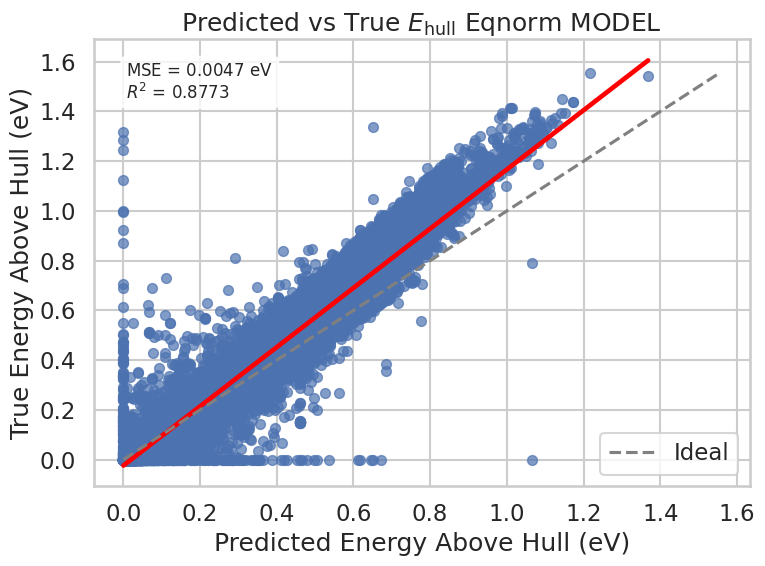

In [4]:
from pymatgen.core import Structure
import pandas as pd
import json
import os
import bz2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

@staticmethod
def kjmol_to_ev(kjmol: float) -> float:
    """Convert kJ/mol to eV."""
    return kjmol * 0.010364

# --- STEP 1: Load CSV with predicted values ---
csv_path = "/content/drive/MyDrive/AML/Results/ehull_results_Eqnorm.csv"
df = pd.read_csv(csv_path)

# Drop missing values if any E_hull_DFT (eV/atom)	E_hull_ML (eV/atom)
# Apply only to float columns
float_cols = df.select_dtypes(include=['float'])
df[float_cols.columns] = float_cols.applymap(kjmol_to_ev)
df.rename(columns={"E_hull_DFT (eV/atom)": "E_hull_DFT", "E_hull_ML (eV/atom)": "E_hull_ML"}, inplace=True)
df.dropna(subset=["E_hull_DFT", "E_hull_ML"], inplace=True)

# --- STEP 4: Compute regression metrics ---
mse = mean_squared_error(df["E_hull_DFT"], df["E_hull_ML"])
r2 = r2_score(df["E_hull_DFT"], df["E_hull_ML"])

# --- STEP 5: Plot ---
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(8, 6))

# Scatter + regression line
sns.regplot(
    data=df,
    x="E_hull_ML",
    y="E_hull_DFT",
    scatter_kws={"s": 50, "alpha": 0.7},
    line_kws={"color": "red"}
)

# Identity line
min_val = min(df["E_hull_DFT"].min(), df["E_hull_ML"].min())
max_val = max(df["E_hull_DFT"].max(), df["E_hull_ML"].max())
plt.plot([min_val, max_val], [min_val, max_val], color="gray", linestyle="--", label="Ideal")

# Labels and title
plt.xlabel("Predicted Energy Above Hull (eV)")
plt.ylabel("True Energy Above Hull (eV)")
plt.title("Predicted vs True $E_{\\mathrm{hull}}$ Eqnorm MODEL")

# Add metrics to plot
plt.text(
    0.05, 0.95,
    f"$\\mathrm{{MSE}}$ = {mse:.4f} eV \n$R^2$ = {r2:.4f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/AML/Results/Eqnorm_results/ehull_results_Eqnorm.png")
plt.show()


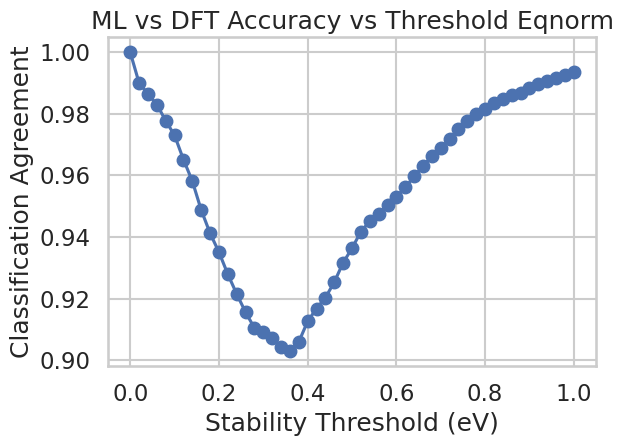

In [8]:
import numpy as np

thresholds = np.linspace(0, 1, 51)  # From 0 to 0.1 eV
accuracies = []

for t in thresholds:
    stable_dft = df['E_hull_DFT'] < t
    stable_ml  = df['E_hull_ML'] < t
    acc = (stable_dft == stable_ml).mean()
    accuracies.append(acc)

# Plot accuracy vs threshold
plt.plot(thresholds, accuracies, marker='o')
plt.xlabel("Stability Threshold (eV)")
plt.ylabel("Classification Agreement")
plt.title("ML vs DFT Accuracy vs Threshold Eqnorm")
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/AML/Results/Eqnorm_results/accuracy_vs_threshold_Eqnorm.png")
plt.show()


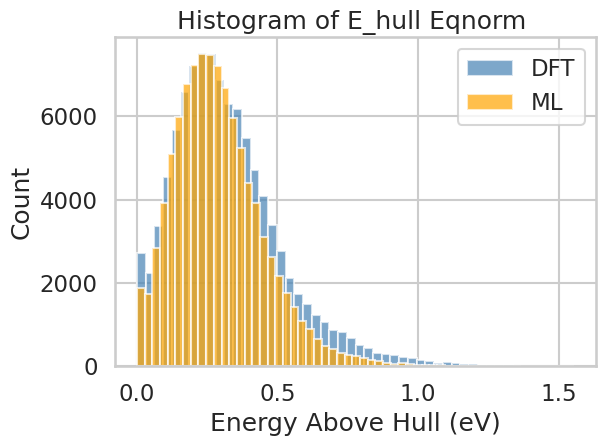

In [9]:
import matplotlib.pyplot as plt

plt.hist(df['E_hull_DFT'], bins=50, alpha=0.7, color='steelblue',label='DFT')
plt.hist(df['E_hull_ML'], bins=50, alpha=0.7, color='orange',label='ML')
plt.xlabel("Energy Above Hull (eV)")
plt.ylabel("Count")
plt.title("Histogram of E_hull Eqnorm ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/AML/Results/Eqnorm_results/histogram_E_hull_Eqnorm.png")
plt.show()


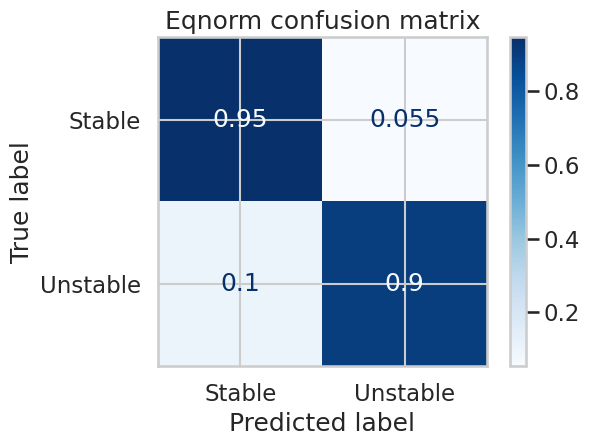

In [10]:
import numpy as np
stability_threshold = 0.25

df['Stable_DFT'] = df['E_hull_DFT'] < stability_threshold
df['Stable_ML'] = df['E_hull_ML'] < stability_threshold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df['Stable_DFT'], df['Stable_ML'], labels=[True, False])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Stable", "Unstable"])
disp.plot(cmap='Blues')
disp.ax_.set_title("Eqnorm confusion matrix")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/AML/Results/Eqnorm_results/confusion_matrix_Eqnorm.png")
plt.show()